# Review Classification Models

## Importing Libraries

In [1]:
# !pip install xgboost
# !pip install lightgbm
# ! apt install -qq enchant
# ! apt install myspell-en
# ! pip install pyenchant

In [2]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
stop_words = set(stopwords.words('english'))
stop_words.update(string.punctuation)
stop_words.update(['stay', 'stayed', 'service', 'got', 'room', 'night', 'food', 'did', 'rooms', 
'day', 'resort', 'hotel', 'beach', 'staff'])
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
import string
import gensim
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif


import optuna
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_roc_curve,plot_confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

optuna.logging.set_verbosity(optuna.logging.ERROR)

pd.set_option('display.max_colwidth',300)

d:\venv_python\text_mining\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA

In [4]:
df = pd.read_csv('../Datasets/tripadvisor_hotel_reviews.csv')
df.shape

(20491, 2)

In [5]:
df.head(10)

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites descr...",2
2,"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't pro...",3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet friendly room showed no signs animal hair smells, monaco suite sleeping area big striped curtains pulled closed nice touch felt cosy, goldfish named brandi enjoyed, did n't partake f...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room huge staff helpful, booked hotels website seahawk package, no charge parking got voucher taxi, problem taxi driver did n't want accept voucher barely spoke english, funny thing speak arabic called sta...",5
5,"love monaco staff husband stayed hotel crazy weekend attending memorial service best friend husband celebrating 12th wedding anniversary, talk mixed emotions, booked suite hotel monte carlos, loaned beautiful fan-tanned goldfish named joliet weekend visited dogs worked desk human companions, roo...",5
6,"cozy stay rainy city, husband spent 7 nights monaco early january 2008. business trip chance come ride.we booked monte carlo suite proved comfortable longish stay, room 905 located street building, street noise not problem view interesting rooms building look dank alley midsection large office b...",5
7,"excellent staff, housekeeping quality hotel chocked staff make feel home, experienced exceptional service desk staff concierge door men maid service needs work, maid failed tuck sheets foot bed instance soiled sheets used, staff quickley resolved soiled sheets issue, guess relates employee not r...",4
8,"hotel stayed hotel monaco cruise, rooms generous decorated uniquely, hotel remodeled pacific bell building charm sturdiness, everytime walked bell men felt like coming home, secure, great single travelers, location fabulous, walk things pike market space needle.little grocery/drug store block aw...",5
9,"excellent stayed hotel monaco past w/e delight, reception staff friendly professional room smart comfortable bed, particularly liked reception small dog received staff guests spoke loved, mild negative distance uphill ppmarket restaurants 1st, overall great experience,",5


In [6]:
print("Rating: ")
df.Rating.value_counts(normalize=True)

Rating: 


5    0.441853
4    0.294715
3    0.106583
2    0.087502
1    0.069348
Name: Rating, dtype: float64

In [7]:
# A new target is created where 0 is a detractor and 1 is a promoter.

conditions = [df.Rating.isin([1,2,3]), df.Rating.isin([4,5])]
values = [0,1]

df['Cluster'] =np.select(conditions, values)
df['Review_original'] = df['Review']


In [8]:
print("Target: ")
df.Cluster.value_counts(normalize=True)

Target: 


1    0.736567
0    0.263433
Name: Cluster, dtype: float64

In [9]:
def get_top_n_words(corpus, n=10):
    cv = CountVectorizer()
    corpus_matrix = cv.fit_transform(corpus)
    corpus_matrix = pd.DataFrame.sparse.from_spmatrix(corpus_matrix, columns=cv.get_feature_names_out())
    aux = corpus_matrix.sum()
    aux=aux.to_frame('count')
    aux.sort_values(by='count',ascending=False,inplace=True)
    aux=aux.head(n)
    return aux

In [10]:
# Amount of tokens in the entire corpus
most_importants = get_top_n_words(df.Review, n=500)
print(most_importants.head(10))
px.bar(most_importants, x=most_importants.index, y='count')

       count
hotel  49814
room   35331
not    31709
great  21475
good   17412
staff  16633
stay   15411
did    14006
just   12667
nice   12643


In [11]:
# Amount of tokens for Detractors
most_importants = get_top_n_words(df[df.Cluster == 0].Review, n=500)
detractores = set(most_importants.index[:100])
print(most_importants.head(10))
px.bar(most_importants, x=most_importants.index, y='count')

       count
not    13819
hotel  13081
room   12331
no      5323
did     5096
good    4664
stay    4073
rooms   3853
staff   3820
just    3542


In [12]:
# Amount of tokens for Promoters
most_importants = get_top_n_words(df[df.Cluster == 1].Review, n=500)
promotores = set(most_importants.index[:100])
print(most_importants.head(10))
px.bar(most_importants, x=most_importants.index, y='count')

          count
hotel     36733
room      23000
great     18455
not       17890
staff     12813
good      12748
stay      11338
nice       9402
just       9125
location   8951


In [13]:
print(promotores)
print("")
print(detractores)

{'going', 'food', 'went', 'location', 'lobby', 'right', 'area', 'floor', 'friendly', 'small', 'just', 'comfortable', 'buffet', 'booked', 'resort', 'recommend', 'bathroom', 'beautiful', 'good', 'great', 'water', 'helpful', 'room', 'big', 'fantastic', 'check', 'no', 'stayed', 'bar', 'station', 'little', 'really', 'took', 'breakfast', 'wonderful', 'the', 'stay', 'want', 'night', 'not', 'way', 'quiet', 'best', 'quite', 'desk', 'excellent', 'walking', 'nice', 'time', 'like', 'experience', 'clean', 'pool', 'perfect', 'make', 'staff', 'say', 'place', 'away', 'shower', 'service', 'city', 'rooms', 'large', 'bit', 'bed', 'better', 'definitely', 'problem', 'hotels', 'beach', 'airport', 'got', 'restaurant', 'restaurants', 'people', 'price', 'walk', 'nights', 'reviews', 'trip', 'week', 'close', 'value', 'lot', 'loved', 'day', 'morning', 'view', 'street', 'lovely', 'enjoyed', 'free', 'we', 'new', '10', 'minutes', 'days', 'did', 'hotel'}

{'going', 'food', 'use', 'arrived', 'went', 'location', 'lobby

In [14]:
# Within the 100 most common promoter words, the ones shown are those that are not repeated with promoters and detractors.
diferencia = promotores-detractores
diferencia

{'airport',
 'big',
 'city',
 'close',
 'comfortable',
 'definitely',
 'enjoyed',
 'excellent',
 'fantastic',
 'helpful',
 'large',
 'loved',
 'lovely',
 'perfect',
 'quiet',
 'recommend',
 'station',
 'street',
 'value',
 'walking',
 'we',
 'wonderful'}

In [15]:
palabras_comunes = detractores - diferencia
len(palabras_comunes)

100

## NLP Process

In [16]:
lista = []
for palabra in df.Review:
  string_encode = palabra.encode("ascii", "ignore")
  string_decode = string_encode.decode()
  lista.append(string_decode)

df['Review'] = lista

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def ch_sep(text):
  """
  Take a text and separate the special characters so that they are taken apart
  """
  clean_text =' '.join(re.findall(r"[^,.:;_~=/'/+/-]+|[,.:;_~=/'/+/-]", text))
  return clean_text



def pre_procesamiento_texto(text):
  # create tokens to process the data
  
  tokens = word_tokenize(text)

  # Deleting the stopwords
  tokens = [t.lower() for t in tokens if t.lower() not in stop_words]
  tokens = [re.sub('\s+', ' ', sent) for sent in tokens]
  tokens = [re.sub('\d', ' ', sent) for sent in tokens] #Removes numbers
  tokens = [re.sub(' +', ' ', sent) for sent in tokens] #Removes multiple whitespaces
  tokens = [str(sent).strip() for sent in tokens] #Removes whitespace before and after the token
  tokens = [re.sub('[^A-Za-z0-9]+', ' ', sent) for sent in tokens] #Removes special characters
  

  stemer = []
  for p in tokens:
    stemer.append(stemmer.stem(p))
  return stemer

In [18]:
df.Review = df.Review.apply(ch_sep)

## Vectorizing Results

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.Review, df.Cluster,test_size=.30)

In [20]:
X_train.shape

(14343,)

In [21]:
cv = TfidfVectorizer(tokenizer=pre_procesamiento_texto)
X_train_transform = cv.fit_transform(X_train)
X_test_transform = cv.transform(X_test)

In [22]:
df_tranform = pd.DataFrame.sparse.from_spmatrix(X_train_transform, columns=cv.get_feature_names_out())
df_tranform

,,,a,a and,a twtt,a yo,aa,aaa,aaaa,aaaaa,...,zum,zumo,zurich,zwoll,zyrtec,zytec,zz,zzzt,zzzzt,zzzzzzzzz
0,0.040715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.169363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.031354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.307011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14338,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14339,0.215211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14340,0.069331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14341,0.257002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Selects the features that best discriminate for each class

y_train = y_train.astype(int)
y_test = y_test.astype(int)

score_fn = chi2 #f_classif #chi2
train_fold = X_train_transform
train_targets_fold = y_train
nombres_features = list(df_tranform.columns)
MAX_FEATURES = 1000 #500
nombres_features = list(df_tranform.columns)
test_fold = X_test_transform

In [24]:
# Selects features from training folds
selector_features = SelectKBest(score_func=score_fn, k=MAX_FEATURES)
selector_features.fit(train_fold, train_targets_fold)

# Leaves in the training fold only the features selected with the training fold
train_selected = selector_features.transform(train_fold)

# Leaves in the test fold only the features selected with the training fold
test_selected = selector_features.transform(test_fold)
selector_features.get_support()

array([ True, False, False, ..., False, False, False])

# Modeling

## Logistic Regression

In [25]:
lr = LogisticRegression()

def objective(trial : optuna.Trial, X, y):

    modelo = lr.set_params(max_iter = 1000,
    solver=  trial.suggest_categorical('solver', ['lbfgs', 'newton-cg']),
    #trial.suggest_categorical('solver', ['lbfgs', 'saga', 'sag', 'liblinear', 'newton-cg', 'newton-cholesky']),
    penalty= trial.suggest_categorical('penalty', [ 'l2', 'none']),
    #trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none']),
    #l1_ratio= trial.suggest_float('l1_ratio', 0, 1),
    C=trial.suggest_float('C', 10e-1, 100))


    # Cross Validation.
    folds = StratifiedKFold(n_splits=3,  shuffle=True, random_state=42)

   
    scores = cross_val_score(
        estimator = modelo, 
        X=X,
        y=y, 
        scoring='average_precision',
        cv=folds, 
    )
    
    
    return np.mean(scores)

study_lgr = optuna.create_study(direction="maximize", study_name='hiperparam_tuning_lgr')


study_lgr.optimize(lambda trial: objective(trial,
                                           X=train_selected,
                                           y=y_train),
                          n_trials=100,
                          timeout= None,
                          n_jobs=-1
                          )

d:\venv_python\text_mining\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

d:\venv_python\text_mining\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

d:\venv_python\text_mining\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

d:\venv_python\text_mining\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

d:\venv_python\text_mining\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

d:\venv_python\text_mining\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

d:\venv_py

In [26]:
lr = LogisticRegression(**study_lgr.best_params)
lr.fit(train_selected, y_train)

LogisticRegression(C=10.525687087573361, solver='newton-cg')

### Results

              precision    recall  f1-score   support

           0       0.83      0.76      0.80      1611
           1       0.92      0.95      0.93      4537

    accuracy                           0.90      6148
   macro avg       0.88      0.85      0.86      6148
weighted avg       0.90      0.90      0.90      6148



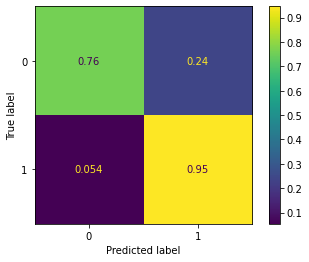

In [27]:
y_pred_lr = lr.predict(test_selected)
print(classification_report(y_test, y_pred_lr))
plot_confusion_matrix(lr,test_selected,y_test,normalize='true')

In [28]:
print(confusion_matrix(y_test, y_pred_lr))

[[1225  386]
 [ 244 4293]]


## SVM

In [29]:
svm = LinearSVC()

def objective(trial : optuna.Trial, X, y):

    modelo = svm.set_params(max_iter = 1000,
    penalty= 'l2',   #trial.suggest_categorical('penalty', [ 'l2', 'l1']),
    C=trial.suggest_float('C', 10e-1, 100),
    dual = trial.suggest_categorical('dual', [ True, False]),
    tol = trial.suggest_float('tol', 10e-5, 0.01),
    )


    # Cross Validation.
    folds = StratifiedKFold(n_splits=3,  shuffle=True, random_state=42)

   
    scores = cross_val_score(
        estimator = modelo, 
        X=X,
        y=y, 
        scoring='average_precision',
        cv=folds, 
    )
    
    
    return np.mean(scores)

try_these_parameters_first = {"penalty":'l2', "loss":'squared_hinge', "dual":True, "tol": 0.0001, "C":1.0}

study_svm = optuna.create_study(direction="maximize", study_name='hiperparam_tuning_svm')
study_svm.enqueue_trial(try_these_parameters_first)
study_svm.optimize(lambda trial: objective(trial,
                                           X=train_selected,
                                           y=y_train),
                          n_trials=100,
                          timeout= None,
                          n_jobs=-1
                          )

C:\Users\John\AppData\Local\Temp\ipykernel_1304\801209374.py:31: ExperimentalWarning:

enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.

d:\venv_python\text_mining\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning:

create_trial is experimental (supported from v2.0.0). The interface can change in the future.

d:\venv_python\text_mining\lib\site-packages\optuna\study\study.py:856: ExperimentalWarning:

add_trial is experimental (supported from v2.0.0). The interface can change in the future.

d:\venv_python\text_mining\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\venv_python\text_mining\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\venv_python\text_mining\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, i

In [30]:
svm = LinearSVC(**study_svm.best_params)
svm.fit(train_selected, y_train)

LinearSVC(C=1.2738618944932287, tol=0.009450589256622795)

### Results

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1611
           1       0.92      0.95      0.93      4537

    accuracy                           0.90      6148
   macro avg       0.88      0.85      0.86      6148
weighted avg       0.90      0.90      0.90      6148



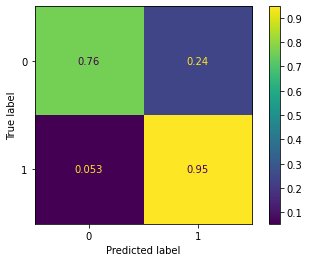

In [31]:
y_pred_svm = svm.predict(test_selected)
print(classification_report(y_test, y_pred_svm))
plot_confusion_matrix(svm,test_selected,y_test,normalize='true')

In [32]:
print(confusion_matrix(y_test, y_pred_svm))

[[1222  389]
 [ 241 4296]]


## Lightgbm


In [33]:
lgbm = LGBMClassifier()
def objective(trial : optuna.Trial, X, y):
    
    max_depth=15

    param_grid_lgbm = {
        "n_estimators": trial.suggest_int('n_estimators', 50, 1500),
        "learning_rate": trial.suggest_float(name='learning_rate', low=0.000001, high=0.1, log=True),
        "num_leaves": trial.suggest_int('num_leaves', 2, min(2**14 - 1, 2**max_depth - 1), log=True),
        "max_depth": trial.suggest_int('max_depth', 2, max_depth), 
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 100, step=5),  
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 100, step=5),  
        "min_split_gain": trial.suggest_float("min_split_gain", 0, 15),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0, step=0.1),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [1,0]),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0, step=0.1),
        'random_state' : 42,
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 0.1),
        "min_child_samples": trial.suggest_int('min_child_samples', 10, 60),
    }

    modelo = lgbm.set_params(**param_grid_lgbm)
    
    folds = StratifiedKFold(n_splits=3,  shuffle=True, random_state=85)

    scores = cross_val_score(
        estimator = modelo, 
        X=X, y=y, 
        scoring='precision',
        cv=folds, 
    )  

    return np.mean(scores)

try_these_parameters_first = {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 10, 
'reg_alpha': 0.0, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'subsample': 1.0, 'subsample_freq': 0, 
'colsample_bytree': 1.0, 'min_child_weight': 0.001, 'min_child_samples': 20}


study_lgbm = optuna.create_study(direction="maximize",study_name='tuning_lightgbm')
study_lgbm.enqueue_trial(try_these_parameters_first)
study_lgbm.optimize(lambda trial: objective(trial,
                                       X=train_selected,
                                       y=y_train),
                                       n_trials=50,
                                       n_jobs=-1)

C:\Users\John\AppData\Local\Temp\ipykernel_1304\3197543796.py:41: ExperimentalWarning:

enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.

d:\venv_python\text_mining\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning:

create_trial is experimental (supported from v2.0.0). The interface can change in the future.

d:\venv_python\text_mining\lib\site-packages\optuna\study\study.py:856: ExperimentalWarning:

add_trial is experimental (supported from v2.0.0). The interface can change in the future.



In [34]:
lgbm = LGBMClassifier(**study_lgbm.best_params)
lgbm.fit(train_selected, y_train)

LGBMClassifier(colsample_bytree=0.6, learning_rate=0.040223692755598416,
               max_depth=13, min_child_samples=55,
               min_child_weight=0.01613551356019533,
               min_split_gain=1.3107811065702162, n_estimators=984,
               num_leaves=1417, reg_alpha=70, reg_lambda=0, subsample=0.9)

### Results

              precision    recall  f1-score   support

           0       0.81      0.51      0.63      1611
           1       0.85      0.96      0.90      4537

    accuracy                           0.84      6148
   macro avg       0.83      0.73      0.76      6148
weighted avg       0.84      0.84      0.83      6148



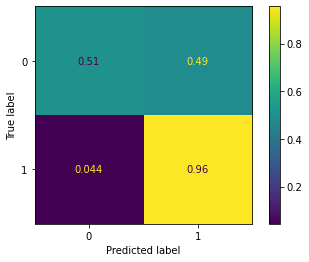

In [35]:
y_pred_lgbm = lgbm.predict(test_selected)
print(classification_report(y_test, y_pred_lgbm))
plot_confusion_matrix(lgbm,test_selected,y_test,normalize='true')

In [36]:
print(confusion_matrix(y_test, y_pred_lgbm))

[[ 827  784]
 [ 199 4338]]
